# Model interpretation (Estimators of all frequencies)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import seaborn as sns
import shap
import statsmodels.api as sm

## Load variables and target

In the first step we load the dataset again and define the explanatory and target variables again:

In [2]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [3]:
# List of explanatory variables
lst_param = df_params.columns.to_list()

# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

# Target variables are frequencies of modes 50 to 85
lst_freq = lst_param[86:122]
Y = df_params[lst_freq]

In [4]:
# New Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=55)

## LightGBM with MultiOutput

We use the LightGBM model again, tuned before:

In [5]:
# Create the main pipeline
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

tuned_regressor = LGBMRegressor(n_estimators=7061,
                      num_leaves=12,
                      min_child_samples=6,
                      learning_rate=0.01404,
                      reg_alpha=1.30466e-5,
                      reg_lambda=5.37035e-5,
                      force_col_wise=True)

pipe_tuned_lgbm = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', MultiOutputRegressor(tuned_regressor))
                        ])

In [6]:
# pipe_tuned_lgbm the bayesian search
pipe_tuned_lgbm.fit(X_train, Y_train)
print ('Score of the test set:', pipe_tuned_lgbm.score(X_test, Y_test))

[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 16668.989118
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 16847.349643
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17015.896527
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17276.652251
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 27
[LightGBM] [Info] Start training from score 17539.445753
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the trai

## Analysis of the residuals

In [7]:
Y_pred_tuned_lgbm = pipe_tuned_lgbm.predict(X_test)
residuals_lgbm = Y_pred_tuned_lgbm-Y_test

The mean absolute percentage error (MAPE) quantifies the average absolute difference between predicted and observed values as percentage of the observed (true) values. This metric is appropriate in our specific case, where the target variables span a broad range of magnitudes (between 13 and 27 kHz). The argument "raw_values" allows to determine the error for each frequency.

In [8]:
mape = mean_absolute_percentage_error(Y_test, Y_pred_tuned_lgbm, multioutput='raw_values')

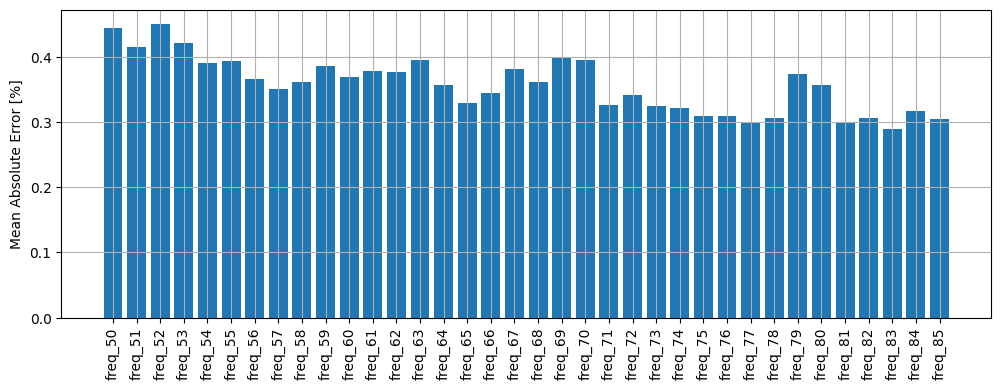

In [9]:
lst_freq = Y_test.columns
n_freq = len(lst_freq)

fig = plt.figure(figsize=(12, 4))
plt.bar(x=range(n_freq), height=mape*100)
plt.ylabel('Mean Absolute Error [%]')
plt.xticks(range(n_freq), lst_freq, rotation=90)
plt.grid()
plt.show()

The MAPE trends to decrease with high frequencies. An error of 0.4 % represents 80 Hz for the range of 20 kHz, which is absolutely acceptable.

The Q-Q plots of the frequency residuals checks the normality of the distribution by comparing the distribution of the actual data with a theoretical distribution (here a standard normal law)

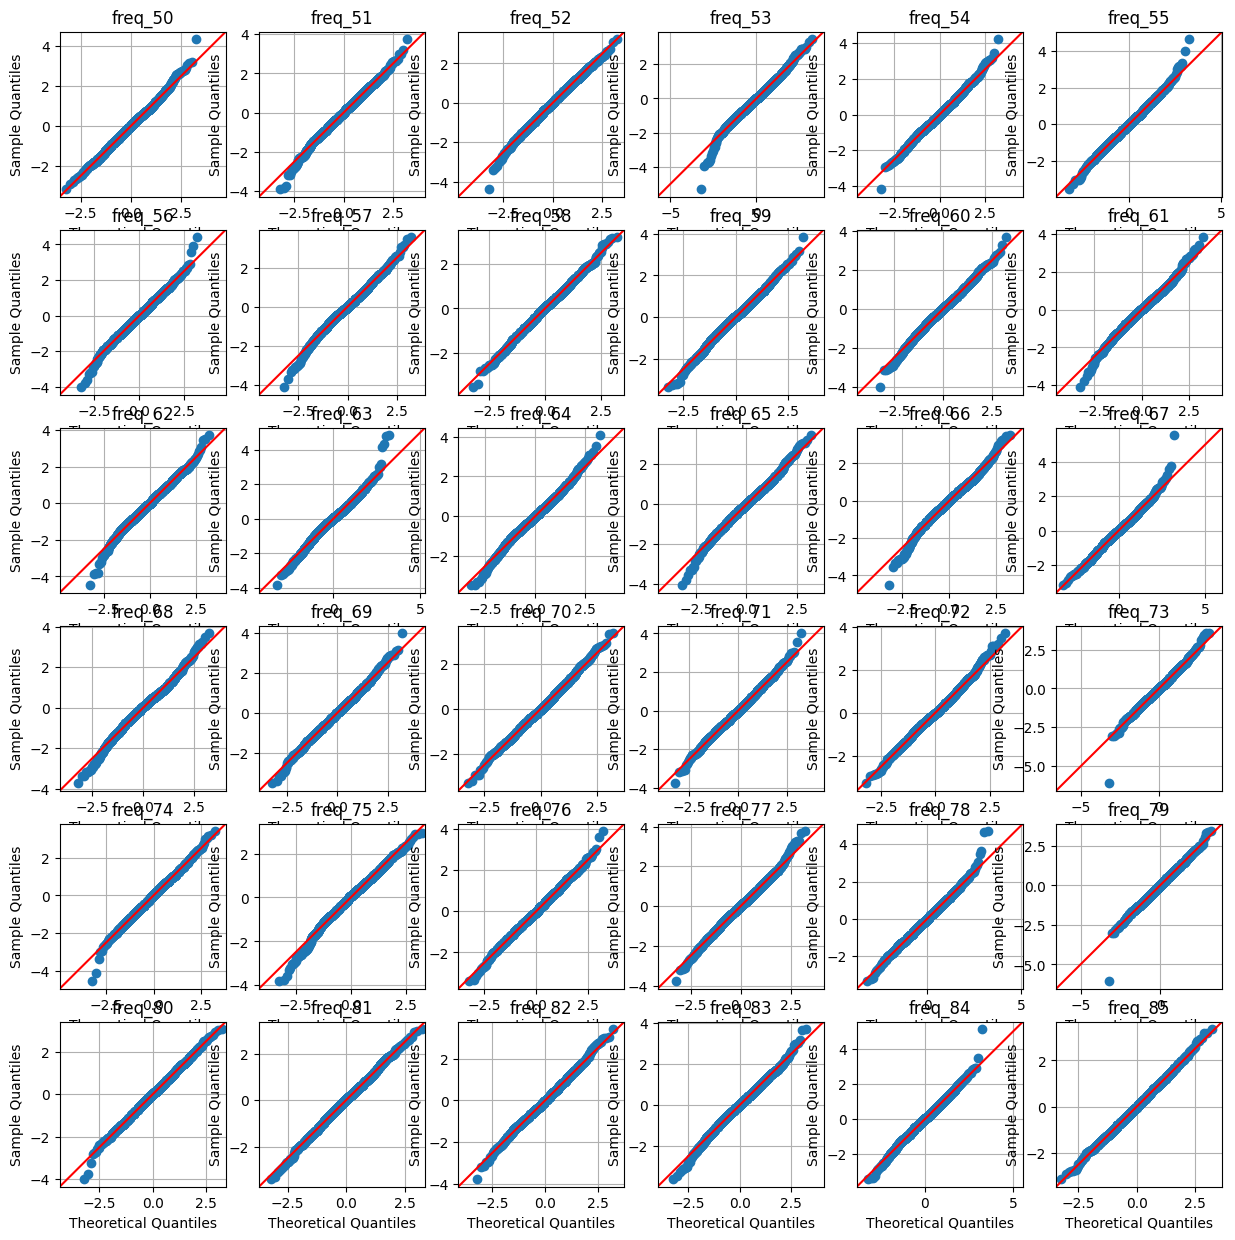

In [58]:
fig = plt.figure(figsize=(15, 15))
plt.tight_layout

for f in range(len(lst_freq)):
    residuals = residuals_lgbm[lst_freq[f]]

    ax = fig.add_subplot(6, 6, f+1)
    sm.qqplot(residuals, fit=True, line='45', ax=ax)
    plt.title(lst_freq[f])
    plt.grid(True)
    plt.plot

plt.show()

* The frequency residuals follow a normal law and are centered around 0
* Some outliers which are existing the normal distribution could be due to the interactions between the modes (see the interpretation of the longitudinal frequency) 